In [12]:
import scipy.io as sio
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import itertools
from collections import defaultdict
from tqdm import tqdm

In [13]:
stats01s = sio.loadmat('16qubit_data/stats_0.mat')['stats01s']
measure_fids = sio.loadmat('16qubit_data/measure_fids.mat')['measure_fids']

# typical correction and get raw value

In [14]:
def findIndex(qNum, qidx):
    order = 2**(qNum-qidx+1)*np.arange(0, 2**(qidx-1))
    index0 = np.reshape(order, [len(order), 1]) + np.arange(0, 2**(qNum-qidx))
    index0 = np.reshape(index0, 2**(qNum-1))
    index1 = index0 + 2**(qNum-qidx)
    return np.int32(index0), np.int32(index1)
def nchoosek(qnum, n=1):
    c = []
    for i in itertools.combinations(range(qnum),n):
        c.append(list(i))
    return c
qnum=16
_basis = np.zeros([2**qnum,qnum])
for i in range(qnum):
    index0,index1 = findIndex(qnum,i+1)
    _basis[index1,i] = 1
ind_occ = nchoosek(qnum=qnum,n=qnum//2)

In [15]:
dim0 = stats01s.shape
qnum=dim0[2]
probs = []
probIndexs = []
binCoeff = 2**np.arange(dim0[2]-1, -1, -1)
probIndexAll = np.arange(2**dim0[2])
for ii in range(dim0[1]):
    pCounter = np.zeros(2**dim0[2], dtype=int)
    for jj in range(dim0[0]):
        pCounter[np.sum(stats01s[jj,ii,:] * binCoeff)] += 1
    probIndex = probIndexAll[pCounter>0]
    prob = pCounter[pCounter>0]
    probs.append(prob)
    probIndexs.append(probIndex)
probs=np.asarray(probs,dtype=object)
probIndexs=np.asarray(probIndexs,dtype=object)
probs_raw=np.zeros([dim0[1],2**qnum])
for i in range(dim0[1]):
    probs_raw[i,probIndexs[i]]=probs[i]/dim0[0]
probs = probs_raw
probIndexs = 0
for ii in range(qnum):
    f0 = measure_fids[ii][0]
    f1 = measure_fids[ii][1]
    corrMat = np.matrix([[f0, 1 - f1], [1 - f0, f1]])
    corrMat = corrMat.I
    indexP0, indexP1 = findIndex(qnum, ii+1)
    probsCorr = np.copy(probs)
    probsCorr[:,indexP0] = probs[:,indexP0]*corrMat[0, 0] + probs[:,indexP1] * corrMat[0, 1]
    probsCorr[:,indexP1] = probs[:,indexP0]*corrMat[1, 0] + probs[:,indexP1] * corrMat[1, 1]
    probs = probsCorr

In [16]:
ini_state = np.sum(stats01s[:,0,:],axis=0)/dim0[0]
ini_state = np.array([1 if i>0.5 else 0 for i in ini_state])
hamming_raw = np.zeros([dim0[1],qnum+1])
for i in range(dim0[0]):
    hamming_raw_tmp = np.array(np.sum(np.abs(stats01s[i,:,:]-ini_state),axis=1),dtype=int)
    for j in range(dim0[1]):
        hamming_raw[j,hamming_raw_tmp[j]]+=1
hamming_raw = hamming_raw/dim0[0]
psi_ini = np.array(ini_state)
psis_temp=np.array(np.sum(np.abs(_basis-psi_ini),axis=1),dtype=np.int32)
hammingdex=[np.where(psis_temp==i)[0] for i in range(qnum+1)]
hamming_corr=np.array([np.sum(probs[:,hammingdex[i]],axis=1) for i in range(qnum+1)]).transpose(1,0)

# sw_rr

In [17]:
meas_mats, meas_mats_inv = [], []
for qubit in range(qnum):
    meas_mat = np.array([[
        measure_fids[qubit][0], 1-measure_fids[qubit][1]],
        [1-measure_fids[qubit][0], measure_fids[qubit][1]]
    ])
    meas_mats.append(meas_mat)
    meas_mats_inv.append(np.linalg.inv(meas_mat))

In [18]:
i=5
stats_num =dim0[0]
stats_counts = {}
stats_strs_tmp = []
stats_strs_type_tmp = []
for j in range(stats_num):
    stat_str = ''.join([str(ii) for ii in stats01s[j,i,:]])
    stats_strs_tmp.append(stat_str)
    if stat_str not in stats_strs_type_tmp:
        stats_strs_type_tmp.append(stat_str)

In [19]:
stats_counts = dict(zip(stats_strs_type_tmp, [stats_strs_tmp.count(stat_str) for stat_str in stats_strs_type_tmp]))

In [23]:
def transform_(matrix, local_basis):
    local_vec = np.zeros(2)
    local_vec[local_basis] = 1
    local_vec = matrix @ local_vec
    return local_vec  # new_basis_value

rm_prob = defaultdict(float)

for basis, prob in tqdm(stats_counts.items()):
    basis = [int(c) for c in basis]
    local_vecs = []
    for qubit in range(qnum):
        local_vecs.append(transform_(meas_mats_inv[qubit], basis[qubit]))

    now_basis_values = [
        [[local_basis], local_value*prob]
        for local_basis, local_value in enumerate(local_vecs[0])
    ]

    for qubit in range(1, qnum):
        next_basis_values = []
        for local_basis, local_value in enumerate(local_vecs[qubit]):
            for basis, value in now_basis_values:
                basis = list(basis)
                next_value = value * local_value

                if np.abs(next_value) < 1e-10:  # 1e-2 ** n_qubits:
                    continue

                basis.append(local_basis)  # 可以改成进制的
                next_basis_values.append([basis, next_value])

        now_basis_values = next_basis_values

    for basis, value in now_basis_values:
        basis = np.array(basis)
        rm_prob[''.join(basis.astype(np.str_))] += value

    new_rm_prob = defaultdict(float)
    for basis, value in rm_prob.items():
        if np.abs(value) < 1e-10:  # 1e-2 ** n_qubits:
            continue
        new_rm_prob[basis] = value
    rm_prob = new_rm_prob

sum_prob = sum(rm_prob.values())
rm_prob = {
    basis: value / sum_prob
    for basis, value in rm_prob.items()
}

100%|██████████| 387/387 [03:07<00:00,  2.06it/s]


In [21]:
hamming_sw_rr=np.zeros([qnum+1])
ini_state_str = ''.join(['1' if ini_i == 1 else '0' for ini_i in ini_state])
for q_str in rm_prob.keys():
    hamming_sw_rr[sum(c1 != c2 for c1, c2 in zip(q_str, ini_state_str))]+=rm_prob[q_str]

# plot result

Text(0, 0.5, 'hamming probs')

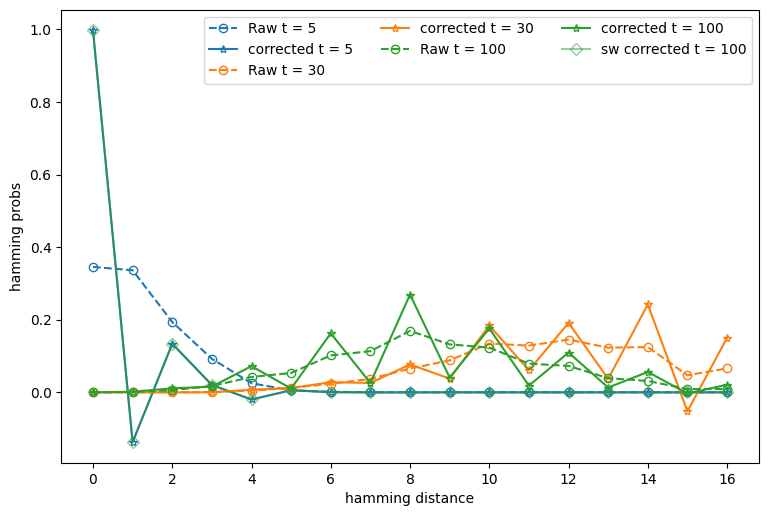

In [22]:
LABEL_COLORS_1 = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:brown', 'tab:pink']
tlist = np.arange(dim0[1])
select_t = [5,30,100]
plt.figure(figsize=(9,6),dpi=100)
for color_i,i in enumerate(select_t):
    plt.plot(np.arange(0,qnum+1,1),hamming_raw[i,:],'o--',color=LABEL_COLORS_1[color_i],
            markerfacecolor='none',label=f'Raw t = {tlist[i]}')
    plt.plot(np.arange(0,qnum+1,1),hamming_corr[i,:],'*-',
            color=LABEL_COLORS_1[color_i],
            markerfacecolor='none',label=f'corrected t = {tlist[i]}')
plt.plot(np.arange(0,qnum+1,1),hamming_sw_rr,'D-',alpha=0.5,
            color=LABEL_COLORS_1[color_i],
            markerfacecolor='none',label=f'sw corrected t = {tlist[i]}')
plt.legend(ncol=len(select_t))
plt.xlabel('hamming distance')
plt.ylabel('hamming probs')